In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet

from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss
# from models_package.models import Teacher, Student

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
learning_rate = 0.001 # 0.096779
epochs = 300
epochs_pretrain = 3
epochs_optimal_lr = 5
patience_teacher = 7
patience_student = 10
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
batch_size = 64
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = True

# list of lambda values to loop through for grid search
lmda_list_student = [10,5,3,0]
lmda_list_teacher = [10,5,3,0]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16
class_names_new = [f"Class {label}" for label in range(num_classes)]

# Create directory and file path to save all outputs
output_dir = f'./runs_{datetime.now().strftime("%Y_%m_%d_%H_%M")}'
os.makedirs(output_dir, exist_ok=True)

In [3]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [5]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water_Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(num_classes):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [6]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [7]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [8]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [9]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [10]:
# train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')

if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [11]:
len(train_dataset)

10324

In [12]:
# def print_batch_class_counts(data_loader, label_mapping, num_batches=5):
#     for i, batch in enumerate(data_loader):
#         if i >= num_batches:
#             break

#         # Extract labels from the batch
#         labels = batch['label']

#         # Count occurrences of each class
#         class_counts = torch.bincount(labels)

#         # Map class counts to class names
#         class_counts_with_names = {label_mapping.get(j, f"Unknown Class {j}"): class_counts[j].item() for j in range(len(class_counts))}

#         # Print class counts and total observations
#         print(f"Batch {i + 1}:")
#         for class_name, count in class_counts_with_names.items():
#             print(f"    {class_name}: {count}")
#         print(f"Total Observations: {len(labels)}\n")

# print_batch_class_counts(trainloader, new_label_mapping)


Batch 1:
Class Counts: tensor([12,  6,  5,  2,  7,  2,  1,  4,  4,  3,  4,  1,  3,  3,  4,  4])
Total Observations: 65
Batch 2:
Class Counts: tensor([12,  6,  5,  2,  7,  2,  1,  4,  4,  3,  4,  1,  3,  3,  4,  4])
Total Observations: 65
Batch 3:
Class Counts: tensor([12,  6,  5,  2,  7,  2,  1,  4,  4,  3,  4,  1,  3,  3,  4,  4])
Total Observations: 65
Batch 4:
Class Counts: tensor([12,  6,  5,  2,  7,  2,  1,  4,  4,  3,  4,  1,  3,  3,  4,  4])
Total Observations: 65
Batch 5:
Class Counts: tensor([12,  6,  5,  2,  7,  2,  1,  4,  4,  3,  4,  1,  3,  3,  4,  4])
Total Observations: 65


# Start Training Process

In [13]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [14]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights=None)
student_model.classifier = nn.Linear(1280, num_classes)

# Load teacher
# teacher_model = torch.load('teacher_model_ckd_wider.pth')
# teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider.pth'))
# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_wider.pth')
# # Load the studnet
# student_model = torch.load('student_model_ckd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_ckd_prof_checkpoint.pth'))
# student_model = student_model.to(device)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [15]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size*2, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()

In [16]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)


In [17]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)


In [18]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
        concatenated_output = torch.cat((student_output, one_hot_labels), dim=1)
        adversary_output = adv(concatenated_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)


In [19]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


In [20]:
# #### finding the optimal learning rate
# def train_teacher_optimal_lr(model, trainloader, criterion, optimizer, scheduler, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Teacher')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Teacher: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_teacher = train_teacher_optimal_lr(teacher_model, trainloader, criterion_clf, teacher_optimizer, teacher_scheduler, device, epochs_optimal_lr)  
# print(best_lr_teacher)


In [21]:
# #### finding the optimal learning rate
# def train_student_optimal_lr(model, trainloader, criterion, optimizer, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Student')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Student: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_student = train_student_optimal_lr(student_model, trainloader, criterion_clf, student_optimizer, device, epochs_optimal_lr)  
# print(best_lr_student)

In [22]:
best_lr_student = learning_rate
best_lr_teacher = learning_rate

In [23]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [24]:
# This is the adversary training function, where we input the student outputs, 
# with the true labels into the adversary model created previously.
def train_adversary(adv, model, optimizer, trainloader, criterion, epochs):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_batches = 0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs and labels
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            model.eval()
            model.to(device)
            adv.train()
            adv.to(device)
            optimizer.zero_grad()
            # output the student model, join with ohe labels. 
            model_output = model(inputs)
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((model_output, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)

            adversary_loss = criterion(adversary_output, targets)
            adversary_loss.backward()
            epoch_loss += adversary_loss.item()
            epoch_batches += 1
            optimizer.step()
        epoch_loss/=epoch_batches
        print("Average Adversary epoch loss:", epoch_loss)

In [25]:
# Function to train the teacher model
def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((teacher_outputs_detached, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                one_hot_labels_val = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                concatenated_output_val = torch.cat((teacher_outputs_detached_val, one_hot_labels_val), dim=1)
                adversary_output_val = adv(concatenated_output_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")
        
        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint{lmda}.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        file_path = os.path.join(output_dir, f'teacher_validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epochs}***********')
            
            file.write("Teacher Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nTeacher Val Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        print(f"Data has been appended to {file_path}")
    
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")
    return val_disparities


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizer, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student, optimizer_adv=None):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        # Train the adversary at the start of each epoch
        train_adversary(adv, student, optimizer_adv, trainloader, adv_criterion, 1)

        student.train()
        student.to(device)
        adv.eval()
        adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 
            studentached = student_outputs.detach()
            # One-hot encode labels and concatenate with student's predictions
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((studentached, one_hot_labels), dim=1)

            # Run the adversarial model on concatenated true labels, and predicted labels
            with torch.no_grad():
                adversary_output = adv(concatenated_output)

            # Calc adversary loss, which is an MSE loss, because this is a regression output. 
            adversary_loss = adv_criterion(adversary_output, targets)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            if lmda != 0:
                loss = (alpha * kd_loss + (1 - alpha) * ce_loss) + (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss - lmda * adversary_loss
            else:
                loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)

                val_studentached = val_student_outputs.detach()   
                val_one_hot_labels = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                val_concatenated_output = torch.cat((val_studentached, val_one_hot_labels), dim=1)
                
                val_adversary_output = adv(val_concatenated_output)
                val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                if lmda != 0:
                    val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) + (alpha * val_kd_loss + (1 - alpha) * val_ce_loss)/val_adversary_loss - lmda * val_adversary_loss
                else:
                    val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(student.state_dict(), f'student_model_weights_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, f'student_model_ckd_wider_checkpoint_lambda{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
    
        file_path = os.path.join(output_dir, f'student_validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epochs}***********')
            
            file.write("Student Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nStudent Val Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
                
    return best_epoch_mean_abs_disparity

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.88it/s]


*****Epoch 1/300*****
*****Train Loss:  0.252511 Val Loss: -2.334622*****
*****Validation Accuracy: 63.55%*****
*****Total Avg Disparity: 0.17641400312236102*****

Class Team_Sports: Recall Difference = 0.08312021953640436
Class Celebration: Recall Difference = -0.06511627906976752
Class Parade: Recall Difference = 0.07276874821785007
Class Waiter_Or_Waitress: Recall Difference = -0.012944983818770184
Class Individual_Sports: Recall Difference = -0.144328335605028
Class Surgeons: Recall Difference = -0.0509977827050998
Class Spa: Recall Difference = -0.7200000000000001
Class Law_Enforcement: Recall Difference = 0.17592592592592582
Class Business: Recall Difference = -0.10412888082791
Class Dresses: Recall Difference = -0.6280487804878049
Class Water Activities: Recall Difference = 0.15935135135135137
Class Picnic: Recall Difference = -0.19999999999999996
Class Rescue: Recall Difference = -0.009620253164556947
Class Cheering: Recall Difference = -0.016201804757998317
Class Performance_A

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.91it/s]


*****Epoch 2/300*****
*****Train Loss: -3.818453 Val Loss: -2.507336*****
*****Validation Accuracy: 63.43%*****
*****Total Avg Disparity: 0.17925335094288783*****

Class Team_Sports: Recall Difference = 0.11550183920126111
Class Celebration: Recall Difference = -0.011627906976744207
Class Parade: Recall Difference = -0.000741374394069072
Class Waiter_Or_Waitress: Recall Difference = -0.11188164586222826
Class Individual_Sports: Recall Difference = -0.105406633348478
Class Surgeons: Recall Difference = -0.04508499630450857
Class Spa: Recall Difference = -0.88
Class Law_Enforcement: Recall Difference = 0.18268268268268262
Class Business: Recall Difference = -0.02976635015469975
Class Dresses: Recall Difference = -0.45325203252032514
Class Water Activities: Recall Difference = 0.10086486486486479
Class Picnic: Recall Difference = -0.32727272727272744
Class Rescue: Recall Difference = -0.043544303797468376
Class Cheering: Recall Difference = -0.1279737489745693
Class Performance_And_Entert

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.92it/s]


*****Epoch 3/300*****
*****Train Loss: -4.949535 Val Loss: -2.724082*****
*****Validation Accuracy: 63.52%*****
*****Total Avg Disparity: 0.1838783060551059*****

Class Team_Sports: Recall Difference = 0.16696444210895067
Class Celebration: Recall Difference = 0.0023255813953487747
Class Parade: Recall Difference = 0.031936127744511045
Class Waiter_Or_Waitress: Recall Difference = 0.09107720758206206
Class Individual_Sports: Recall Difference = -0.10093896713615036
Class Surgeons: Recall Difference = -0.09386548410938655
Class Spa: Recall Difference = -0.9200000000000002
Class Law_Enforcement: Recall Difference = 0.14564564564564564
Class Business: Recall Difference = -0.042035634268643984
Class Dresses: Recall Difference = -0.4607046070460705
Class Water Activities: Recall Difference = 0.13783783783783765
Class Picnic: Recall Difference = -0.34545454545454546
Class Rescue: Recall Difference = 0.05974683544303799
Class Cheering: Recall Difference = 0.03527481542247751
Class Performance

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:22<00:00,  2.38it/s]


*****Epoch 4/300*****
*****Train Loss: -5.513584 Val Loss: -1.947611*****
*****Validation Accuracy: 61.13%*****
*****Total Avg Disparity: 0.13763238565612623*****

Class Team_Sports: Recall Difference = 0.09507794710106865
Class Celebration: Recall Difference = -0.07674418604651162
Class Parade: Recall Difference = 0.05423438836612493
Class Waiter_Or_Waitress: Recall Difference = 0.052242256125751285
Class Individual_Sports: Recall Difference = -0.090564894744813
Class Surgeons: Recall Difference = 0.02734663710273466
Class Spa: Recall Difference = -0.6400000000000001
Class Law_Enforcement: Recall Difference = 0.09484484484484468
Class Business: Recall Difference = -0.044596180518510664
Class Dresses: Recall Difference = -0.4668021680216802
Class Water Activities: Recall Difference = 0.060864864864864865
Class Picnic: Recall Difference = -0.036363636363636376
Class Rescue: Recall Difference = -0.12354430379746834
Class Cheering: Recall Difference = -0.052502050861361726
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.32it/s]


*****Epoch 5/300*****
*****Train Loss: -5.777697 Val Loss: -1.827887*****
*****Validation Accuracy: 61.27%*****
*****Total Avg Disparity: 0.1605231176443131*****

Class Team_Sports: Recall Difference = 0.06387575173702353
Class Celebration: Recall Difference = -0.048837209302325546
Class Parade: Recall Difference = -0.03963501568291983
Class Waiter_Or_Waitress: Recall Difference = -0.0527045769764215
Class Individual_Sports: Recall Difference = -0.0813266696955931
Class Surgeons: Recall Difference = -0.002956393200295615
Class Spa: Recall Difference = -0.5
Class Law_Enforcement: Recall Difference = 0.12187187187187165
Class Business: Recall Difference = -0.04022191400832181
Class Dresses: Recall Difference = -0.7317073170731707
Class Water Activities: Recall Difference = 0.11437837837837828
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.012405063291139218
Class Cheering: Recall Difference = -0.09659557013945858
Class Performance_And_Entertainment: Recall Diff

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:22<00:00,  2.38it/s]


*****Epoch 6/300*****
*****Train Loss: -5.873738 Val Loss: -1.514883*****
*****Validation Accuracy: 61.30%*****
*****Total Avg Disparity: 0.18158527335509012*****

Class Team_Sports: Recall Difference = 0.1578209844105798
Class Celebration: Recall Difference = 0.009302325581395432
Class Parade: Recall Difference = -0.047504990019960225
Class Waiter_Or_Waitress: Recall Difference = -0.06148867313915851
Class Individual_Sports: Recall Difference = -0.08666515220354387
Class Surgeons: Recall Difference = 0.06356245380635633
Class Spa: Recall Difference = -0.78
Class Law_Enforcement: Recall Difference = 0.06806806806806809
Class Business: Recall Difference = 0.02208471140509971
Class Dresses: Recall Difference = -0.6524390243902439
Class Water Activities: Recall Difference = 0.11827027027027015
Class Picnic: Recall Difference = -0.3636363636363636
Class Rescue: Recall Difference = 0.11645569620253166
Class Cheering: Recall Difference = -0.009639048400328143
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:22<00:00,  2.37it/s]


*****Epoch 7/300*****
*****Train Loss: -6.011253 Val Loss: -1.727476*****
*****Validation Accuracy: 61.76%*****
*****Total Avg Disparity: 0.17930850275632465*****

Class Team_Sports: Recall Difference = 0.10747941846207754
Class Celebration: Recall Difference = -0.10930232558139535
Class Parade: Recall Difference = -0.008896492728828087
Class Waiter_Or_Waitress: Recall Difference = -0.07119741100323618
Class Individual_Sports: Recall Difference = -0.013100106012418733
Class Surgeons: Recall Difference = -0.015521064301552145
Class Spa: Recall Difference = -0.64
Class Law_Enforcement: Recall Difference = 0.18743743743743735
Class Business: Recall Difference = -0.06604075536114373
Class Dresses: Recall Difference = -0.6646341463414634
Class Water Activities: Recall Difference = 0.10194594594594586
Class Picnic: Recall Difference = -0.4363636363636364
Class Rescue: Recall Difference = 0.03569620253164563
Class Cheering: Recall Difference = -0.030557834290401986
Class Performance_And_Enter

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.30it/s]


*****Epoch 8/300*****
*****Train Loss: -6.152691 Val Loss: -1.249090*****
*****Validation Accuracy: 61.62%*****
*****Total Avg Disparity: 0.15876522854489447*****

Class Team_Sports: Recall Difference = 0.0906405091376189
Class Celebration: Recall Difference = -0.07906976744186045
Class Parade: Recall Difference = 0.0188765326489877
Class Waiter_Or_Waitress: Recall Difference = 0.06287563569116972
Class Individual_Sports: Recall Difference = -0.25613357564743294
Class Surgeons: Recall Difference = 0.02734663710273466
Class Spa: Recall Difference = -0.6199999999999999
Class Law_Enforcement: Recall Difference = 0.2127127127127127
Class Business: Recall Difference = -0.062199935986343824
Class Dresses: Recall Difference = -0.5338753387533876
Class Water Activities: Recall Difference = 0.10032432432432437
Class Picnic: Recall Difference = 0.09090909090909083
Class Rescue: Recall Difference = -0.04886075949367086
Class Cheering: Recall Difference = -0.024200164068908958
Class Performance_An

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.88it/s]


*****Epoch 9/300*****
*****Train Loss: -6.109406 Val Loss: -1.513612*****
*****Validation Accuracy: 61.90%*****
*****Total Avg Disparity: 0.1698334052686671*****

Class Team_Sports: Recall Difference = 0.07795877853681332
Class Celebration: Recall Difference = -0.016279069767441867
Class Parade: Recall Difference = -0.01978899344168794
Class Waiter_Or_Waitress: Recall Difference = -0.14008321775312083
Class Individual_Sports: Recall Difference = -0.15155989701650763
Class Surgeons: Recall Difference = 0.014781966001478186
Class Spa: Recall Difference = -0.6
Class Law_Enforcement: Recall Difference = 0.06931931931931934
Class Business: Recall Difference = -0.062199935986343824
Class Dresses: Recall Difference = -0.6205962059620596
Class Water Activities: Recall Difference = 0.09535135135135131
Class Picnic: Recall Difference = -0.21818181818181814
Class Rescue: Recall Difference = 0.08506329113924055
Class Cheering: Recall Difference = -0.07136997538966366
Class Performance_And_Entertai

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.97it/s]


*****Epoch 10/300*****
*****Train Loss: -6.277833 Val Loss: -1.161957*****
*****Validation Accuracy: 61.10%*****
*****Total Avg Disparity: 0.16358688786643838*****

Class Team_Sports: Recall Difference = 0.1242599404449114
Class Celebration: Recall Difference = -0.006976744186046546
Class Parade: Recall Difference = -0.047790134017678954
Class Waiter_Or_Waitress: Recall Difference = -0.09939898289412852
Class Individual_Sports: Recall Difference = -0.12986521278206864
Class Surgeons: Recall Difference = -0.057649667405765104
Class Spa: Recall Difference = -0.64
Class Law_Enforcement: Recall Difference = 0.13363363363363367
Class Business: Recall Difference = -0.012909420676410988
Class Dresses: Recall Difference = -0.6449864498644988
Class Water Activities: Recall Difference = 0.05178378378378368
Class Picnic: Recall Difference = -0.27272727272727265
Class Rescue: Recall Difference = 0.0017721518987341423
Class Cheering: Recall Difference = -0.0010254306808859526
Class Performance_And_

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.95it/s]


*****Epoch 11/300*****
*****Train Loss: -6.211325 Val Loss: -1.058572*****
*****Validation Accuracy: 61.39%*****
*****Total Avg Disparity: 0.15546056829623126*****

Class Team_Sports: Recall Difference = 0.08783791673965069
Class Celebration: Recall Difference = -0.02790697674418613
Class Parade: Recall Difference = 0.03301967493584257
Class Waiter_Or_Waitress: Recall Difference = 0.04253351826167362
Class Individual_Sports: Recall Difference = -0.12672270180221124
Class Surgeons: Recall Difference = 0.08130081300813008
Class Spa: Recall Difference = -0.82
Class Law_Enforcement: Recall Difference = 0.13363363363363367
Class Business: Recall Difference = -0.06091966286141043
Class Dresses: Recall Difference = -0.459349593495935
Class Water Activities: Recall Difference = 0.06389189189189193
Class Picnic: Recall Difference = -0.16363636363636358
Class Rescue: Recall Difference = 0.028354430379746887
Class Cheering: Recall Difference = 0.05414273995077934
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.98it/s]


*****Epoch 12/300*****
*****Train Loss: -6.249282 Val Loss: -0.181482*****
*****Validation Accuracy: 58.30%*****
*****Total Avg Disparity: 0.1424425790154456*****

Class Team_Sports: Recall Difference = 0.12571962398551995
Class Celebration: Recall Difference = -0.04651162790697677
Class Parade: Recall Difference = 0.04094667807242647
Class Waiter_Or_Waitress: Recall Difference = 0.015256588072122046
Class Individual_Sports: Recall Difference = 0.027260336210813252
Class Surgeons: Recall Difference = -0.04508499630450846
Class Spa: Recall Difference = -0.64
Class Law_Enforcement: Recall Difference = 0.0072572572572572325
Class Business: Recall Difference = -0.06860130161101025
Class Dresses: Recall Difference = -0.5548780487804877
Class Water Activities: Recall Difference = 0.1088648648648648
Class Picnic: Recall Difference = -0.16363636363636358
Class Rescue: Recall Difference = -0.00025316455696200446
Class Cheering: Recall Difference = -0.06460213289581629
Class Performance_And_Ente

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.90it/s]


*****Epoch 13/300*****
*****Train Loss: -6.269140 Val Loss: -0.988446*****
*****Validation Accuracy: 59.62%*****
*****Total Avg Disparity: 0.1648227334308864*****

Class Team_Sports: Recall Difference = 0.07195655981783144
Class Celebration: Recall Difference = -0.039534883720930225
Class Parade: Recall Difference = 0.05566010835471913
Class Waiter_Or_Waitress: Recall Difference = 0.03282478039759584
Class Individual_Sports: Recall Difference = -0.13319703165227936
Class Surgeons: Recall Difference = 0.05764966740576499
Class Spa: Recall Difference = -0.8
Class Law_Enforcement: Recall Difference = 0.0998498498498499
Class Business: Recall Difference = -0.08876560332871014
Class Dresses: Recall Difference = -0.5535230352303524
Class Water Activities: Recall Difference = 0.1008648648648649
Class Picnic: Recall Difference = -0.29090909090909084
Class Rescue: Recall Difference = 0.028354430379746887
Class Cheering: Recall Difference = -0.00594749794913868
Class Performance_And_Entertainmen

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.94it/s]


*****Epoch 14/300*****
*****Train Loss: -6.213952 Val Loss: -0.413549*****
*****Validation Accuracy: 60.58%*****
*****Total Avg Disparity: 0.16215250939755357*****

Class Team_Sports: Recall Difference = 0.08373912535762251
Class Celebration: Recall Difference = -0.1093023255813953
Class Parade: Recall Difference = -0.012717422298260561
Class Waiter_Or_Waitress: Recall Difference = -0.024503005085529383
Class Individual_Sports: Recall Difference = -0.0524004240496746
Class Surgeons: Recall Difference = -0.07021433850702147
Class Spa: Recall Difference = -0.6600000000000001
Class Law_Enforcement: Recall Difference = 0.18718718718718708
Class Business: Recall Difference = -0.13272164728475405
Class Dresses: Recall Difference = -0.6266937669376693
Class Water Activities: Recall Difference = 0.060864864864864754
Class Picnic: Recall Difference = 0.018181818181818077
Class Rescue: Recall Difference = 0.07443037974683542
Class Cheering: Recall Difference = 0.04532403609515995
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.94it/s]


*****Epoch 15/300*****
*****Train Loss: -6.233259 Val Loss: -0.897687*****
*****Validation Accuracy: 60.38%*****
*****Total Avg Disparity: 0.15191002536054984*****

Class Team_Sports: Recall Difference = 0.120161149062883
Class Celebration: Recall Difference = -0.06511627906976747
Class Parade: Recall Difference = 0.012888508696891954
Class Waiter_Or_Waitress: Recall Difference = 0.014331946370781501
Class Individual_Sports: Recall Difference = -0.02661668938361339
Class Surgeons: Recall Difference = -0.008869179600887067
Class Spa: Recall Difference = -0.5000000000000001
Class Law_Enforcement: Recall Difference = 0.07282282282282282
Class Business: Recall Difference = -0.15011202389843176
Class Dresses: Recall Difference = -0.6829268292682927
Class Water Activities: Recall Difference = 0.07437837837837824
Class Picnic: Recall Difference = -0.29090909090909084
Class Rescue: Recall Difference = 0.04177215189873412
Class Cheering: Recall Difference = -0.05762920426579157
Class Performanc

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.88it/s]


*****Epoch 16/300*****
*****Train Loss: -6.320365 Val Loss: -0.970614*****
*****Validation Accuracy: 60.78%*****
*****Total Avg Disparity: 0.16145229028441727*****

Class Team_Sports: Recall Difference = 0.09440065393822605
Class Celebration: Recall Difference = 0.05813953488372098
Class Parade: Recall Difference = -0.008326204733390519
Class Waiter_Or_Waitress: Recall Difference = -0.1285251964863614
Class Individual_Sports: Recall Difference = -0.114644858397698
Class Surgeons: Recall Difference = 0.02734663710273466
Class Spa: Recall Difference = -0.6200000000000001
Class Law_Enforcement: Recall Difference = 0.15190190190190195
Class Business: Recall Difference = 0.0019204096873999266
Class Dresses: Recall Difference = -0.6890243902439025
Class Water Activities: Recall Difference = 0.15491891891891885
Class Picnic: Recall Difference = -0.16363636363636358
Class Rescue: Recall Difference = -0.0022784810126582067
Class Cheering: Recall Difference = -0.04819524200164066
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.87it/s]


*****Epoch 17/300*****
*****Train Loss: -6.335999 Val Loss: -0.540562*****
*****Validation Accuracy: 60.09%*****
*****Total Avg Disparity: 0.1474280718735011*****

Class Team_Sports: Recall Difference = 0.09967886962106609
Class Celebration: Recall Difference = 0.0488372093023256
Class Parade: Recall Difference = 0.0164242942686057
Class Waiter_Or_Waitress: Recall Difference = -0.13915857605177984
Class Individual_Sports: Recall Difference = -0.04850068150840514
Class Surgeons: Recall Difference = -0.009608277900960804
Class Spa: Recall Difference = -0.58
Class Law_Enforcement: Recall Difference = 0.07607607607607614
Class Business: Recall Difference = -0.15651338952309818
Class Dresses: Recall Difference = -0.5962059620596207
Class Water Activities: Recall Difference = 0.0363243243243242
Class Picnic: Recall Difference = -0.10909090909090913
Class Rescue: Recall Difference = 0.08177215189873421
Class Cheering: Recall Difference = -0.059680065627563506
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.96it/s]


*****Epoch 18/300*****
*****Train Loss: -6.438469 Val Loss: -0.293517*****
*****Validation Accuracy: 59.42%*****
*****Total Avg Disparity: 0.1452306339862892*****

Class Team_Sports: Recall Difference = 0.02661295031237243
Class Celebration: Recall Difference = -0.01627906976744181
Class Parade: Recall Difference = -0.011063587111491469
Class Waiter_Or_Waitress: Recall Difference = -0.005085529357373941
Class Individual_Sports: Recall Difference = -0.046683325761017636
Class Surgeons: Recall Difference = -0.10051736881005174
Class Spa: Recall Difference = -0.54
Class Law_Enforcement: Recall Difference = 0.11986986986986997
Class Business: Recall Difference = -0.07169529499626592
Class Dresses: Recall Difference = -0.6280487804878049
Class Water Activities: Recall Difference = 0.10086486486486479
Class Picnic: Recall Difference = -0.12727272727272732
Class Rescue: Recall Difference = -0.03949367088607594
Class Cheering: Recall Difference = -0.05803937653814595
Class Performance_And_Ente

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.96it/s]


*****Epoch 19/300*****
*****Train Loss: -6.290619 Val Loss: -0.815152*****
*****Validation Accuracy: 60.20%*****
*****Total Avg Disparity: 0.167872602590942*****

Class Team_Sports: Recall Difference = 0.04799439481520407
Class Celebration: Recall Difference = -0.06279069767441858
Class Parade: Recall Difference = -0.041003706871970524
Class Waiter_Or_Waitress: Recall Difference = -0.09939898289412852
Class Individual_Sports: Recall Difference = -0.07648038770255938
Class Surgeons: Recall Difference = -0.10643015521064308
Class Spa: Recall Difference = -0.52
Class Law_Enforcement: Recall Difference = 0.0745745745745745
Class Business: Recall Difference = -0.012909420676410877
Class Dresses: Recall Difference = -0.6510840108401084
Class Water Activities: Recall Difference = -0.028216216216216283
Class Picnic: Recall Difference = -0.4545454545454546
Class Rescue: Recall Difference = 0.07974683544303801
Class Cheering: Recall Difference = -0.04306808859721084
Class Performance_And_Enterta

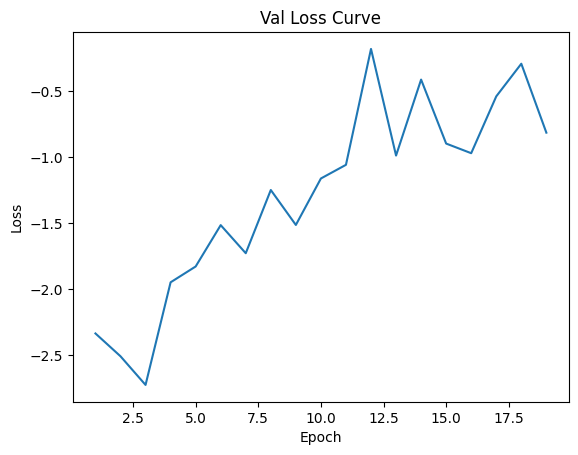

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 10


100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.89it/s]


*****Epoch 1/300*****
*****Train Loss:  2.300319 Val Loss:  0.302432*****
*****Validation Accuracy: 62.83%*****
*****Total Avg Disparity: 0.16515107385401442*****

Class Team_Sports: Recall Difference = 0.046417936591347075
Class Celebration: Recall Difference = -0.030232558139534682
Class Parade: Recall Difference = -0.026062161391502747
Class Waiter_Or_Waitress: Recall Difference = 0.02496532593619971
Class Individual_Sports: Recall Difference = -0.14527487505679226
Class Surgeons: Recall Difference = -0.02660753880266087
Class Spa: Recall Difference = -0.86
Class Law_Enforcement: Recall Difference = 0.11686686686686676
Class Business: Recall Difference = -0.11970553718126531
Class Dresses: Recall Difference = -0.4668021680216802
Class Water Activities: Recall Difference = 0.13091891891891894
Class Picnic: Recall Difference = 0.1272727272727272
Class Rescue: Recall Difference = 0.031139240506329158
Class Cheering: Recall Difference = -0.04757998359310911
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.85it/s]


*****Epoch 2/300*****
*****Train Loss: -0.731765 Val Loss:  0.236126*****
*****Validation Accuracy: 62.66%*****
*****Total Avg Disparity: 0.20934376703374402*****

Class Team_Sports: Recall Difference = 0.06583756641560123
Class Celebration: Recall Difference = -0.086046511627907
Class Parade: Recall Difference = -0.02412318220701437
Class Waiter_Or_Waitress: Recall Difference = -0.054553860379103036
Class Individual_Sports: Recall Difference = -0.1799182189913675
Class Surgeons: Recall Difference = -0.13673318551367325
Class Spa: Recall Difference = -0.7999999999999999
Class Law_Enforcement: Recall Difference = 0.19269269269269274
Class Business: Recall Difference = -0.01931078630107752
Class Dresses: Recall Difference = -0.7256097560975611
Class Water Activities: Recall Difference = 0.14691891891891895
Class Picnic: Recall Difference = 0.4363636363636364
Class Rescue: Recall Difference = -0.00354430379746834
Class Cheering: Recall Difference = -0.036710418375717785
Class Performance_

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.89it/s]


*****Epoch 3/300*****
*****Train Loss: -1.786450 Val Loss:  0.626274*****
*****Validation Accuracy: 61.65%*****
*****Total Avg Disparity: 0.14192154474415153*****

Class Team_Sports: Recall Difference = 0.12633852980673776
Class Celebration: Recall Difference = -0.006976744186046546
Class Parade: Recall Difference = -0.010265183917878562
Class Waiter_Or_Waitress: Recall Difference = 0.03282478039759584
Class Individual_Sports: Recall Difference = -0.09018627896410736
Class Surgeons: Recall Difference = -0.07538802660753885
Class Spa: Recall Difference = -0.7
Class Law_Enforcement: Recall Difference = 0.15040040040040037
Class Business: Recall Difference = -0.10743625306732102
Class Dresses: Recall Difference = -0.5826558265582656
Class Water Activities: Recall Difference = 0.06583783783783792
Class Picnic: Recall Difference = -0.07272727272727275
Class Rescue: Recall Difference = 0.010379746835443127
Class Cheering: Recall Difference = 0.06501230516817064
Class Performance_And_Entertai

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.88it/s]


*****Epoch 4/300*****
*****Train Loss: -2.281616 Val Loss:  0.965288*****
*****Validation Accuracy: 61.39%*****
*****Total Avg Disparity: 0.1643455634856073*****

Class Team_Sports: Recall Difference = 0.07161791323641042
Class Celebration: Recall Difference = -0.037209302325581395
Class Parade: Recall Difference = -0.018420302252637577
Class Waiter_Or_Waitress: Recall Difference = 0.03190013869625519
Class Individual_Sports: Recall Difference = -0.017757080115099133
Class Surgeons: Recall Difference = -0.033259423503326
Class Spa: Recall Difference = -0.7200000000000001
Class Law_Enforcement: Recall Difference = 0.10810810810810823
Class Business: Recall Difference = -0.18051851061559804
Class Dresses: Recall Difference = -0.5230352303523036
Class Water Activities: Recall Difference = 0.04897297297297287
Class Picnic: Recall Difference = -0.3272727272727273
Class Rescue: Recall Difference = 0.027594936708860707
Class Cheering: Recall Difference = -0.011894995898277194
Class Performanc

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.85it/s]


*****Epoch 5/300*****
*****Train Loss: -2.571945 Val Loss:  1.535864*****
*****Validation Accuracy: 60.09%*****
*****Total Avg Disparity: 0.162129493188373*****

Class Team_Sports: Recall Difference = 0.11387867110410477
Class Celebration: Recall Difference = -0.13023255813953494
Class Parade: Recall Difference = 0.06923296264613621
Class Waiter_Or_Waitress: Recall Difference = 0.00554785020804438
Class Individual_Sports: Recall Difference = -0.03365894290474014
Class Surgeons: Recall Difference = -0.08130081300813008
Class Spa: Recall Difference = -0.54
Class Law_Enforcement: Recall Difference = 0.06106106106106113
Class Business: Recall Difference = -0.08471140509975472
Class Dresses: Recall Difference = -0.5230352303523036
Class Water Activities: Recall Difference = 0.0873513513513513
Class Picnic: Recall Difference = 0.2727272727272727
Class Rescue: Recall Difference = 0.16506329113924045
Class Cheering: Recall Difference = -0.0559885151763741
Class Performance_And_Entertainment: R

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.90it/s]


*****Epoch 6/300*****
*****Train Loss: -2.742827 Val Loss:  1.533915*****
*****Validation Accuracy: 60.69%*****
*****Total Avg Disparity: 0.16388510607982387*****

Class Team_Sports: Recall Difference = 0.07369650259823668
Class Celebration: Recall Difference = -0.05581395348837204
Class Parade: Recall Difference = 0.0706016538351868
Class Waiter_Or_Waitress: Recall Difference = -0.08090614886731373
Class Individual_Sports: Recall Difference = 0.06179009541117675
Class Surgeons: Recall Difference = -0.03991130820399119
Class Spa: Recall Difference = -0.64
Class Law_Enforcement: Recall Difference = 0.14039039039039036
Class Business: Recall Difference = -0.04534300650805506
Class Dresses: Recall Difference = -0.7378048780487804
Class Water Activities: Recall Difference = 0.09837837837837826
Class Picnic: Recall Difference = 0.23636363636363644
Class Rescue: Recall Difference = -0.014936708860759484
Class Cheering: Recall Difference = -0.023379819524200096
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.89it/s]


*****Epoch 7/300*****
*****Train Loss: -2.841945 Val Loss:  1.908802*****
*****Validation Accuracy: 59.65%*****
*****Total Avg Disparity: 0.17277604578723493*****

Class Team_Sports: Recall Difference = 0.10523734454370282
Class Celebration: Recall Difference = 0.06046511627906975
Class Parade: Recall Difference = 0.08964927288280589
Class Waiter_Or_Waitress: Recall Difference = 0.06195099398982906
Class Individual_Sports: Recall Difference = -0.032901711343328754
Class Surgeons: Recall Difference = -0.09977827050997778
Class Spa: Recall Difference = -0.68
Class Law_Enforcement: Recall Difference = 0.13488488488488487
Class Business: Recall Difference = -0.12557345567054307
Class Dresses: Recall Difference = -0.6327913279132791
Class Water Activities: Recall Difference = 0.1339459459459459
Class Picnic: Recall Difference = -0.07272727272727275
Class Rescue: Recall Difference = 0.15569620253164557
Class Cheering: Recall Difference = -0.03342904019688264
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.86it/s]


*****Epoch 8/300*****
*****Train Loss: -2.917460 Val Loss:  2.053898*****
*****Validation Accuracy: 60.26%*****
*****Total Avg Disparity: 0.19014543226533331*****

Class Team_Sports: Recall Difference = 0.07997898055701536
Class Celebration: Recall Difference = -0.05813953488372087
Class Parade: Recall Difference = 0.09808953521528363
Class Waiter_Or_Waitress: Recall Difference = -0.07212205270457706
Class Individual_Sports: Recall Difference = -0.12005906406179012
Class Surgeons: Recall Difference = -0.15594974131559491
Class Spa: Recall Difference = -0.56
Class Law_Enforcement: Recall Difference = 0.22447447447447444
Class Business: Recall Difference = -0.09570041608876562
Class Dresses: Recall Difference = -0.7865853658536585
Class Water Activities: Recall Difference = 0.07081081081081075
Class Picnic: Recall Difference = -0.21818181818181814
Class Rescue: Recall Difference = 0.07037974683544301
Class Cheering: Recall Difference = -0.0916735028712059
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.89it/s]


*****Epoch 9/300*****
*****Train Loss: -2.823676 Val Loss:  2.045321*****
*****Validation Accuracy: 59.13%*****
*****Total Avg Disparity: 0.16787528942419377*****

Class Team_Sports: Recall Difference = 0.10327552986512523
Class Celebration: Recall Difference = 0.004651162790697605
Class Parade: Recall Difference = 0.08337610493299119
Class Waiter_Or_Waitress: Recall Difference = -0.13730929264909852
Class Individual_Sports: Recall Difference = -0.08257610177192187
Class Surgeons: Recall Difference = -0.06282335550628249
Class Spa: Recall Difference = -0.44
Class Law_Enforcement: Recall Difference = 0.203953953953954
Class Business: Recall Difference = -0.12610690280593195
Class Dresses: Recall Difference = -0.7134146341463414
Class Water Activities: Recall Difference = 0.04735135135135127
Class Picnic: Recall Difference = 0.23636363636363644
Class Rescue: Recall Difference = 0.02632911392405063
Class Cheering: Recall Difference = -0.010254306808859748
Class Performance_And_Entertainme

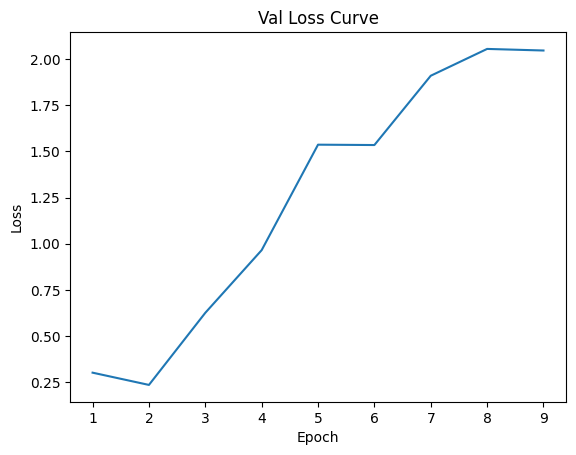

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 5


100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.91it/s]


*****Epoch 1/300*****
*****Train Loss:  5.166132 Val Loss:  2.981962*****
*****Validation Accuracy: 62.54%*****
*****Total Avg Disparity: 0.17254337186039148*****

Class Team_Sports: Recall Difference = 0.08340047877620116
Class Celebration: Recall Difference = 0.0023255813953488857
Class Parade: Recall Difference = 0.013972055888223478
Class Waiter_Or_Waitress: Recall Difference = 0.07258437355524738
Class Individual_Sports: Recall Difference = -0.14489625927608663
Class Surgeons: Recall Difference = -0.05099778270509969
Class Spa: Recall Difference = -0.8200000000000001
Class Law_Enforcement: Recall Difference = 0.12337337337337351
Class Business: Recall Difference = -0.15139229702336504
Class Dresses: Recall Difference = -0.676829268292683
Class Water Activities: Recall Difference = 0.09837837837837826
Class Picnic: Recall Difference = 0.054545454545454564
Class Rescue: Recall Difference = 0.09974683544303803
Class Cheering: Recall Difference = -0.017022149302707124
Class Performanc

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.96it/s]


*****Epoch 2/300*****
*****Train Loss:  1.420869 Val Loss:  2.529675*****
*****Validation Accuracy: 63.20%*****
*****Total Avg Disparity: 0.1478390293964223*****

Class Team_Sports: Recall Difference = 0.08519880889823073
Class Celebration: Recall Difference = -0.046511627906976716
Class Parade: Recall Difference = -0.0001710863986312816
Class Waiter_Or_Waitress: Recall Difference = 0.061026352288488295
Class Individual_Sports: Recall Difference = -0.020142359533545373
Class Surgeons: Recall Difference = -0.05838876570583884
Class Spa: Recall Difference = -0.8
Class Law_Enforcement: Recall Difference = 0.13188188188188188
Class Business: Recall Difference = -0.13634908780539845
Class Dresses: Recall Difference = -0.3482384823848238
Class Water Activities: Recall Difference = 0.12789189189189187
Class Picnic: Recall Difference = -0.03636363636363649
Class Rescue: Recall Difference = 0.08101265822784809
Class Cheering: Recall Difference = -0.07629204265791628
Class Performance_And_Entert

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.92it/s]


*****Epoch 3/300*****
*****Train Loss: -0.212086 Val Loss:  2.236125*****
*****Validation Accuracy: 61.73%*****
*****Total Avg Disparity: 0.1663303924290674*****

Class Team_Sports: Recall Difference = 0.117019910083494
Class Celebration: Recall Difference = 0.07441860465116273
Class Parade: Recall Difference = 0.10025662959794701
Class Waiter_Or_Waitress: Recall Difference = -0.11881645862228385
Class Individual_Sports: Recall Difference = -0.11225957897925187
Class Surgeons: Recall Difference = 0.02734663710273466
Class Spa: Recall Difference = -0.7200000000000001
Class Law_Enforcement: Recall Difference = 0.06631631631631629
Class Business: Recall Difference = -0.07244212098581038
Class Dresses: Recall Difference = -0.4898373983739837
Class Water Activities: Recall Difference = 0.10086486486486479
Class Picnic: Recall Difference = 0.18181818181818177
Class Rescue: Recall Difference = 0.02506329113924055
Class Cheering: Recall Difference = 0.02584085315832657
Class Performance_And_En

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.86it/s]


*****Epoch 4/300*****
*****Train Loss: -1.060710 Val Loss:  2.399723*****
*****Validation Accuracy: 60.87%*****
*****Total Avg Disparity: 0.15039023214351374*****

Class Team_Sports: Recall Difference = 0.12628014246511354
Class Celebration: Recall Difference = -0.009302325581395321
Class Parade: Recall Difference = -0.03855146849158819
Class Waiter_Or_Waitress: Recall Difference = -0.07119741100323618
Class Individual_Sports: Recall Difference = -0.04868998939875813
Class Surgeons: Recall Difference = 0.05838876570583884
Class Spa: Recall Difference = -0.58
Class Law_Enforcement: Recall Difference = 0.14539539539539537
Class Business: Recall Difference = -0.08727195134962135
Class Dresses: Recall Difference = -0.5474254742547424
Class Water Activities: Recall Difference = 0.11189189189189175
Class Picnic: Recall Difference = -0.05454545454545445
Class Rescue: Recall Difference = 0.07974683544303807
Class Cheering: Recall Difference = -0.0676784249384742
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.88it/s]


*****Epoch 5/300*****
*****Train Loss: -1.279162 Val Loss:  2.821331*****
*****Validation Accuracy: 59.94%*****
*****Total Avg Disparity: 0.14137590770549494*****

Class Team_Sports: Recall Difference = 0.06729724995620934
Class Celebration: Recall Difference = -0.06511627906976752
Class Parade: Recall Difference = -0.04533789563729684
Class Waiter_Or_Waitress: Recall Difference = -0.005085529357374052
Class Individual_Sports: Recall Difference = -0.05240042404967438
Class Surgeons: Recall Difference = -0.06430155210643018
Class Spa: Recall Difference = -0.5800000000000001
Class Law_Enforcement: Recall Difference = 0.04754754754754764
Class Business: Recall Difference = 0.008535154166222081
Class Dresses: Recall Difference = -0.524390243902439
Class Water Activities: Recall Difference = 0.13535135135135146
Class Picnic: Recall Difference = -0.18181818181818188
Class Rescue: Recall Difference = 0.1356962025316456
Class Cheering: Recall Difference = -0.023584905660377353
Class Performanc

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.92it/s]


*****Epoch 6/300*****
*****Train Loss: -1.406727 Val Loss:  2.896055*****
*****Validation Accuracy: 60.35%*****
*****Total Avg Disparity: 0.14722973066319495*****

Class Team_Sports: Recall Difference = 0.11865475564897543
Class Celebration: Recall Difference = -0.044186046511627886
Class Parade: Recall Difference = 0.005531793555745734
Class Waiter_Or_Waitress: Recall Difference = -0.003236245954692629
Class Individual_Sports: Recall Difference = -0.0737164925034075
Class Surgeons: Recall Difference = 0.09386548410938655
Class Spa: Recall Difference = -0.54
Class Law_Enforcement: Recall Difference = 0.030780780780780725
Class Business: Recall Difference = -0.12151925744158742
Class Dresses: Recall Difference = -0.6266937669376693
Class Water Activities: Recall Difference = 0.14086486486486494
Class Picnic: Recall Difference = -0.03636363636363649
Class Rescue: Recall Difference = 0.13037974683544307
Class Cheering: Recall Difference = -0.06378178835110748
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.93it/s]


*****Epoch 7/300*****
*****Train Loss: -1.508259 Val Loss:  3.138801*****
*****Validation Accuracy: 60.20%*****
*****Total Avg Disparity: 0.19264715149943107*****

Class Team_Sports: Recall Difference = 0.15776259706895546
Class Celebration: Recall Difference = -0.020930232558139528
Class Parade: Recall Difference = 0.003364699173082464
Class Waiter_Or_Waitress: Recall Difference = 0.04253351826167373
Class Individual_Sports: Recall Difference = -0.08189459336665139
Class Surgeons: Recall Difference = -0.12564671101256458
Class Spa: Recall Difference = -0.8600000000000001
Class Law_Enforcement: Recall Difference = 0.14714714714714705
Class Business: Recall Difference = -0.09570041608876556
Class Dresses: Recall Difference = -0.7378048780487805
Class Water Activities: Recall Difference = 0.1008648648648649
Class Picnic: Recall Difference = -0.509090909090909
Class Rescue: Recall Difference = -0.02886075949367084
Class Cheering: Recall Difference = -0.02050861361771944
Class Performance_

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.95it/s]


*****Epoch 8/300*****
*****Train Loss: -1.505667 Val Loss:  3.196711*****
*****Validation Accuracy: 59.42%*****
*****Total Avg Disparity: 0.14677108670512334*****

Class Team_Sports: Recall Difference = 0.06275471477783634
Class Celebration: Recall Difference = -0.009302325581395432
Class Parade: Recall Difference = 0.09016253207869984
Class Waiter_Or_Waitress: Recall Difference = -0.03328710124826617
Class Individual_Sports: Recall Difference = -0.058117522338330896
Class Surgeons: Recall Difference = -0.039911308203991136
Class Spa: Recall Difference = -0.68
Class Law_Enforcement: Recall Difference = 0.052552552552552645
Class Business: Recall Difference = -0.06476048223621039
Class Dresses: Recall Difference = -0.4681571815718157
Class Water Activities: Recall Difference = 0.16291891891891885
Class Picnic: Recall Difference = 0.18181818181818188
Class Rescue: Recall Difference = 0.1124050632911392
Class Cheering: Recall Difference = -0.08572600492206728
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.95it/s]


*****Epoch 9/300*****
*****Train Loss: -1.594347 Val Loss:  3.480134*****
*****Validation Accuracy: 60.52%*****
*****Total Avg Disparity: 0.1431567635756181*****

Class Team_Sports: Recall Difference = 0.059496701115198225
Class Celebration: Recall Difference = -0.07441860465116285
Class Parade: Recall Difference = 0.013458796692329633
Class Waiter_Or_Waitress: Recall Difference = -0.023578363384188727
Class Individual_Sports: Recall Difference = -0.14470695138573375
Class Surgeons: Recall Difference = -0.008869179600886845
Class Spa: Recall Difference = -0.38
Class Law_Enforcement: Recall Difference = 0.11011011011011007
Class Business: Recall Difference = -0.09698068921369879
Class Dresses: Recall Difference = -0.4972899728997291
Class Water Activities: Recall Difference = 0.09037837837837837
Class Picnic: Recall Difference = -0.41818181818181815
Class Rescue: Recall Difference = 0.016455696202531622
Class Cheering: Recall Difference = -0.07711238720262509
Class Performance_And_Enter

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.90it/s]


*****Epoch 10/300*****
*****Train Loss: -1.677726 Val Loss:  3.305451*****
*****Validation Accuracy: 60.43%*****
*****Total Avg Disparity: 0.1777456655929078*****

Class Team_Sports: Recall Difference = 0.07397676183803359
Class Celebration: Recall Difference = -0.011627906976744207
Class Parade: Recall Difference = 0.05018534359851712
Class Waiter_Or_Waitress: Recall Difference = 0.08229311141932505
Class Individual_Sports: Recall Difference = -0.12339088293200051
Class Surgeons: Recall Difference = -0.1611234294161124
Class Spa: Recall Difference = -0.54
Class Law_Enforcement: Recall Difference = 0.13488488488488493
Class Business: Recall Difference = -0.09132614957857682
Class Dresses: Recall Difference = -0.7439024390243902
Class Water Activities: Recall Difference = 0.11989189189189176
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.07164556962025309
Class Cheering: Recall Difference = -0.04655455291222316
Class Performance_And_Entertainment: Recall Diffe

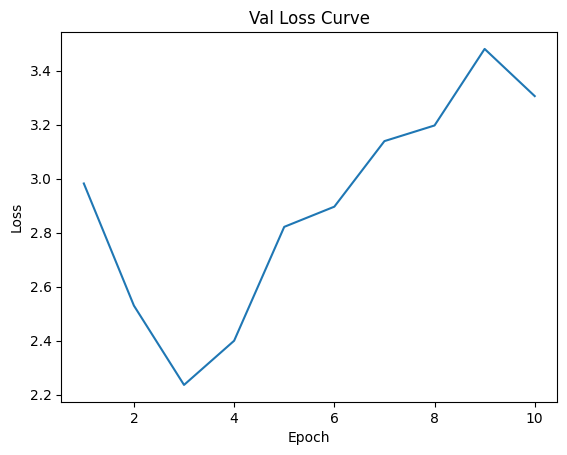

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 3


100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.90it/s]


*****Epoch 1/300*****
*****Train Loss:  1.487526 Val Loss:  1.290437*****
*****Validation Accuracy: 60.49%*****
*****Total Avg Disparity: 0.1661592665166609*****

Class Team_Sports: Recall Difference = 0.04681497051439254
Class Celebration: Recall Difference = -0.06511627906976736
Class Parade: Recall Difference = 0.12854291417165675
Class Waiter_Or_Waitress: Recall Difference = -0.013869625520111062
Class Individual_Sports: Recall Difference = -0.085226412236862
Class Surgeons: Recall Difference = 0.11308203991130827
Class Spa: Recall Difference = -0.52
Class Law_Enforcement: Recall Difference = 0.16891891891891886
Class Business: Recall Difference = -0.07244212098581038
Class Dresses: Recall Difference = -0.6876693766937669
Class Water Activities: Recall Difference = 0.1008648648648649
Class Picnic: Recall Difference = 0.1454545454545454
Class Rescue: Recall Difference = 0.07037974683544312
Class Cheering: Recall Difference = 0.04819524200164069
Class Performance_And_Entertainment: R

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.90it/s]


*****Epoch 2/300*****
*****Train Loss:  0.871364 Val Loss:  1.299808*****
*****Validation Accuracy: 62.08%*****
*****Total Avg Disparity: 0.17660935177611692*****

Class Team_Sports: Recall Difference = 0.11090091668126356
Class Celebration: Recall Difference = -0.039534883720930225
Class Parade: Recall Difference = 0.09073282007413741
Class Waiter_Or_Waitress: Recall Difference = 0.041608876560332964
Class Individual_Sports: Recall Difference = -0.060199909132212515
Class Surgeons: Recall Difference = -0.056910569105691144
Class Spa: Recall Difference = -0.8000000000000002
Class Law_Enforcement: Recall Difference = 0.2432432432432433
Class Business: Recall Difference = -0.05249119812226616
Class Dresses: Recall Difference = -0.7012195121951219
Class Water Activities: Recall Difference = 0.09145945945945944
Class Picnic: Recall Difference = 0.018181818181818188
Class Rescue: Recall Difference = 0.13164556962025314
Class Cheering: Recall Difference = -0.12284659557013952
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.93it/s]


*****Epoch 3/300*****
*****Train Loss:  0.526227 Val Loss:  1.478699*****
*****Validation Accuracy: 61.53%*****
*****Total Avg Disparity: 0.17225746713604417*****

Class Team_Sports: Recall Difference = 0.1210019267822735
Class Celebration: Recall Difference = -0.11627906976744179
Class Parade: Recall Difference = -0.020017108639863057
Class Waiter_Or_Waitress: Recall Difference = -0.02542764678686993
Class Individual_Sports: Recall Difference = -0.12986521278206864
Class Surgeons: Recall Difference = -0.07538802660753874
Class Spa: Recall Difference = -0.54
Class Law_Enforcement: Recall Difference = 0.0843343343343343
Class Business: Recall Difference = 0.036914541768910625
Class Dresses: Recall Difference = -0.7195121951219512
Class Water Activities: Recall Difference = 0.06529729729729716
Class Picnic: Recall Difference = -0.2727272727272727
Class Rescue: Recall Difference = 0.07696202531645563
Class Cheering: Recall Difference = -0.14232977850697298
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.94it/s]


*****Epoch 4/300*****
*****Train Loss:  0.346838 Val Loss:  1.620823*****
*****Validation Accuracy: 61.33%*****
*****Total Avg Disparity: 0.15549426358021967*****

Class Team_Sports: Recall Difference = 0.10035616278390846
Class Celebration: Recall Difference = -0.1046511627906977
Class Parade: Recall Difference = -0.026860564585115543
Class Waiter_Or_Waitress: Recall Difference = -0.12852519648636163
Class Individual_Sports: Recall Difference = -0.04441163107678325
Class Surgeons: Recall Difference = 0.008869179600886845
Class Spa: Recall Difference = -0.6600000000000001
Class Law_Enforcement: Recall Difference = 0.16566566566566565
Class Business: Recall Difference = -0.05633201749706601
Class Dresses: Recall Difference = -0.6890243902439024
Class Water Activities: Recall Difference = 0.06529729729729716
Class Picnic: Recall Difference = 0.018181818181818132
Class Rescue: Recall Difference = -0.018227848101265764
Class Cheering: Recall Difference = 0.017227235438884325
Class Performa

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.91it/s]


*****Epoch 5/300*****
*****Train Loss:  0.246595 Val Loss:  1.804225*****
*****Validation Accuracy: 61.79%*****
*****Total Avg Disparity: 0.15876642647113015*****

Class Team_Sports: Recall Difference = 0.03901442167338098
Class Celebration: Recall Difference = -0.11627906976744184
Class Parade: Recall Difference = -0.03666951810664365
Class Waiter_Or_Waitress: Recall Difference = -0.04207119741100329
Class Individual_Sports: Recall Difference = -0.09389671361502361
Class Surgeons: Recall Difference = -0.07021433850702147
Class Spa: Recall Difference = -0.6200000000000001
Class Law_Enforcement: Recall Difference = 0.08108108108108114
Class Business: Recall Difference = -0.12685372879547635
Class Dresses: Recall Difference = -0.6510840108401086
Class Water Activities: Recall Difference = 0.07686486486486488
Class Picnic: Recall Difference = -0.12727272727272732
Class Rescue: Recall Difference = 0.15164556962025305
Class Cheering: Recall Difference = -0.003896636587366664
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.89it/s]


*****Epoch 6/300*****
*****Train Loss:  0.187855 Val Loss:  1.880027*****
*****Validation Accuracy: 60.87%*****
*****Total Avg Disparity: 0.15464761087349493*****

Class Team_Sports: Recall Difference = 0.09041863723944643
Class Celebration: Recall Difference = -0.09534883720930232
Class Parade: Recall Difference = 0.015055603079555335
Class Waiter_Or_Waitress: Recall Difference = -0.1752196024040683
Class Individual_Sports: Recall Difference = 0.011547781311525007
Class Surgeons: Recall Difference = -0.11160384331116024
Class Spa: Recall Difference = -0.74
Class Law_Enforcement: Recall Difference = 0.005755755755755709
Class Business: Recall Difference = -0.027205803904833015
Class Dresses: Recall Difference = -0.45460704607046065
Class Water Activities: Recall Difference = 0.03740540540540538
Class Picnic: Recall Difference = -0.1636363636363637
Class Rescue: Recall Difference = 0.11037974683544294
Class Cheering: Recall Difference = 0.029532403609515978
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.87it/s]


*****Epoch 7/300*****
*****Train Loss:  0.153909 Val Loss:  1.848263*****
*****Validation Accuracy: 61.88%*****
*****Total Avg Disparity: 0.14578976048178724*****

Class Team_Sports: Recall Difference = 0.06443627021661702
Class Celebration: Recall Difference = 5.551115123125783e-17
Class Parade: Recall Difference = 0.08309096093527224
Class Waiter_Or_Waitress: Recall Difference = -0.043920480813684715
Class Individual_Sports: Recall Difference = -0.013289413902771385
Class Surgeons: Recall Difference = -0.027346637102734606
Class Spa: Recall Difference = -0.68
Class Law_Enforcement: Recall Difference = 0.108108108108108
Class Business: Recall Difference = -0.09313986983889905
Class Dresses: Recall Difference = -0.552168021680217
Class Water Activities: Recall Difference = 0.09232432432432414
Class Picnic: Recall Difference = 0.07272727272727264
Class Rescue: Recall Difference = 0.11037974683544305
Class Cheering: Recall Difference = 0.02378999179655461
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.90it/s]


*****Epoch 8/300*****
*****Train Loss:  0.138354 Val Loss:  1.974810*****
*****Validation Accuracy: 60.89%*****
*****Total Avg Disparity: 0.1683766255000373*****

Class Team_Sports: Recall Difference = 0.10949962048227968
Class Celebration: Recall Difference = -0.11627906976744179
Class Parade: Recall Difference = 0.01859138865126886
Class Waiter_Or_Waitress: Recall Difference = -0.035136384650947594
Class Individual_Sports: Recall Difference = -0.05705739815235489
Class Surgeons: Recall Difference = 0.015521064301551979
Class Spa: Recall Difference = -0.8200000000000001
Class Law_Enforcement: Recall Difference = 0.11361361361361355
Class Business: Recall Difference = -0.11053024645257659
Class Dresses: Recall Difference = -0.5779132791327912
Class Water Activities: Recall Difference = 0.06778378378378369
Class Picnic: Recall Difference = -0.1454545454545454
Class Rescue: Recall Difference = 0.1037974683544304
Class Cheering: Recall Difference = -0.06255127153404433
Class Performance_A

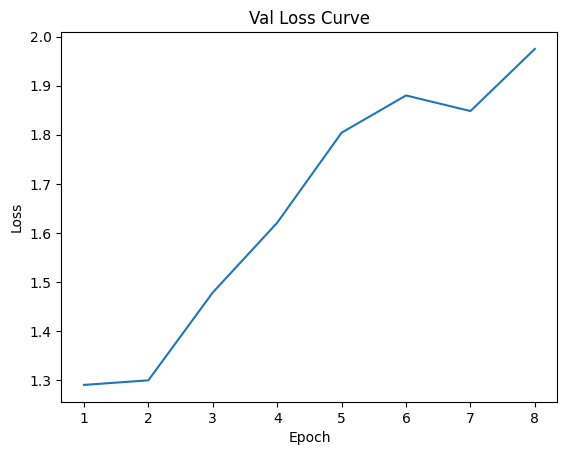

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 0


In [26]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # Replace the last fully connected layer with a new one
    teacher_model.classifier = nn.Linear(1536, num_classes)
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=best_lr_teacher)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_teacher)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # Save the teacher model and its state
    torch.save(teacher_model.state_dict(), f'teacher_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(teacher_model, f'teacher_model_ckd_wider_lambda{i}.pth')
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


In [ ]:
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # load teacher model with lambda 0
    teacher_model = torch.load('teacher_model_ckd_wider_lambda0.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda0.pth'))
    teacher_model = teacher_model.to(device)
    
    # # Reset the student model for each lambda
    student_model = torchvision.models.efficientnet_b0(weights=None)
    student_model.classifier = nn.Linear(1280, num_classes)
    student_optimizer = optim.Adam(student_model.parameters(), lr=best_lr_student)
    student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)
    
    adv = Adversary()
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_student)

    pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
    pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, adv_criterion, student_optimizer, device, alpha, temperature, epochs, lmda=0, patience=patience_student, optimizer_adv=student_optimizer_adv)

    torch.save(student_model.state_dict(), f'student_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(student_model, f'student_model_ckd_wider_lambda{i}.pth')
    print('Student weights and architecture saved and exported for lambda:', i)

    # Check if the key exists in the dictionary
    if i not in lambda_results:
        # If not, create a new entry for that key
        lambda_results[i] = {
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        }
    else:
        # If the key exists, update the existing entry
        lambda_results[i].update({
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        })


100%|█████████████████████████████████████████████████████████████████████████| 161/161 [01:22<00:00,  1.95it/s]


*******Epoch 0: loss - 1.280115338586132


100%|█████████████████████████████████████████████████████████████████████████| 161/161 [01:22<00:00,  1.95it/s]


*******Epoch 1: loss - 1.1886339979882565


100%|█████████████████████████████████████████████████████████████████████████| 161/161 [01:22<00:00,  1.95it/s]


*******Epoch 2: loss - 1.1371552414775634


100%|█████████████████████████████████████████████████████████████████████████| 161/161 [01:42<00:00,  1.57it/s]


Average Pretrain Adversary epoch loss:  0.37134633643656784


100%|█████████████████████████████████████████████████████████████████████████| 161/161 [01:42<00:00,  1.57it/s]


Average Pretrain Adversary epoch loss:  0.3713579224133343


100%|█████████████████████████████████████████████████████████████████████████| 161/161 [01:42<00:00,  1.57it/s]


Average Pretrain Adversary epoch loss:  0.3713367807198755


100%|█████████████████████████████████████████████████████████████████████████| 161/161 [00:59<00:00,  2.70it/s]


Average Adversary epoch loss: 0.2714322510158053


100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:19<00:00,  2.72it/s]


*****Epoch 1/300*****
*****Train Loss:  1.086075 Val Loss:  0.719439*****
*****Validation Accuracy: 35.27%*****
*****Total Avg Disparity: 0.11554208707368566*****

Class Team_Sports: Recall Difference = 0.17157704209727342
Class Celebration: Recall Difference = -0.08604651162790697
Class Parade: Recall Difference = -0.08936412888508694
Class Waiter_Or_Waitress: Recall Difference = -0.01710587147480358
Class Individual_Sports: Recall Difference = -0.04066333484779644
Class Surgeons: Recall Difference = 0.07982261640798229
Class Spa: Recall Difference = -0.38
Class Law_Enforcement: Recall Difference = 0.18343343343343355
Class Business: Recall Difference = -0.054518297236743785
Class Dresses: Recall Difference = -0.19241192411924118
Class Water Activities: Recall Difference = 0.01859459459459467
Class Picnic: Recall Difference = 0.3818181818181818
Class Rescue: Recall Difference = -0.007341772151898733
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Di

100%|█████████████████████████████████████████████████████████████████████████| 161/161 [00:57<00:00,  2.79it/s]


Average Adversary epoch loss: 0.21479314639701608


100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.68it/s]


*****Epoch 2/300*****
*****Train Loss:  1.043859 Val Loss:  0.759058*****
*****Validation Accuracy: 33.39%*****
*****Total Avg Disparity: 0.09401443878396845*****

Class Team_Sports: Recall Difference = 0.11102936883283704
Class Celebration: Recall Difference = 0.018604651162790725
Class Parade: Recall Difference = -0.09404049044767615
Class Waiter_Or_Waitress: Recall Difference = 0.09061488673139154
Class Individual_Sports: Recall Difference = -0.024307133121308555
Class Surgeons: Recall Difference = 0.0672579453067258
Class Spa: Recall Difference = -0.1
Class Law_Enforcement: Recall Difference = 0.16216216216216228
Class Business: Recall Difference = -0.06774778619438816
Class Dresses: Recall Difference = 0.04471544715447151
Class Water Activities: Recall Difference = 0.10875675675675672
Class Picnic: Recall Difference = 0.309090909090909
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0478746060

100%|█████████████████████████████████████████████████████████████████████████| 161/161 [00:58<00:00,  2.74it/s]


Average Adversary epoch loss: 0.2076936146209699


100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:19<00:00,  2.77it/s]


*****Epoch 3/300*****
*****Train Loss:  0.997721 Val Loss:  0.726690*****
*****Validation Accuracy: 34.66%*****
*****Total Avg Disparity: 0.09414410522145725*****

Class Team_Sports: Recall Difference = 0.10311204530857698
Class Celebration: Recall Difference = -0.07674418604651165
Class Parade: Recall Difference = 0.008611348731109247
Class Waiter_Or_Waitress: Recall Difference = -0.06749884419787328
Class Individual_Sports: Recall Difference = 0.03517340602756325
Class Surgeons: Recall Difference = -0.016999260901699953
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.164914914914915
Class Business: Recall Difference = 0.00021337885415553814
Class Dresses: Recall Difference = -0.3997289972899729
Class Water Activities: Recall Difference = 0.05967567567567561
Class Picnic: Recall Difference = 0.12727272727272732
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.009433962264150943
Class Performance_And_Entertainment: Recall Diffe

100%|█████████████████████████████████████████████████████████████████████████| 161/161 [00:57<00:00,  2.78it/s]


Average Adversary epoch loss: 0.19918108282622343


100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:19<00:00,  2.78it/s]


*****Epoch 4/300*****
*****Train Loss:  0.962554 Val Loss:  0.707927*****
*****Validation Accuracy: 37.98%*****
*****Total Avg Disparity: 0.09162178249284278*****

Class Team_Sports: Recall Difference = 0.04895194721784302
Class Celebration: Recall Difference = -0.10930232558139533
Class Parade: Recall Difference = -0.0017108639863130382
Class Waiter_Or_Waitress: Recall Difference = -0.007397133610725859
Class Individual_Sports: Recall Difference = -0.14553990610328632
Class Surgeons: Recall Difference = 0.03843311160384333
Class Spa: Recall Difference = -0.30000000000000004
Class Law_Enforcement: Recall Difference = 0.1011011011011011
Class Business: Recall Difference = -0.14083004374266508
Class Dresses: Recall Difference = -0.2791327913279133
Class Water Activities: Recall Difference = 0.07048648648648648
Class Picnic: Recall Difference = 0.018181818181818188
Class Rescue: Recall Difference = -0.014683544303797473
Class Cheering: Recall Difference = -0.010869565217391306
Class Perfo

100%|█████████████████████████████████████████████████████████████████████████| 161/161 [00:58<00:00,  2.76it/s]


Average Adversary epoch loss: 0.18353772265200288


100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:19<00:00,  2.72it/s]


*****Epoch 5/300*****
*****Train Loss:  0.917476 Val Loss:  0.774077*****
*****Validation Accuracy: 34.75%*****
*****Total Avg Disparity: 0.12822837710406237*****

Class Team_Sports: Recall Difference = 0.13763064167688438
Class Celebration: Recall Difference = 0.01395348837209301
Class Parade: Recall Difference = -0.060507556315939515
Class Waiter_Or_Waitress: Recall Difference = -0.09107720758206198
Class Individual_Sports: Recall Difference = -0.08121308496138124
Class Surgeons: Recall Difference = 0.04434589800443467
Class Spa: Recall Difference = -0.52
Class Law_Enforcement: Recall Difference = 0.1941941941941942
Class Business: Recall Difference = -0.14595113624239836
Class Dresses: Recall Difference = -0.3157181571815718
Class Water Activities: Recall Difference = 0.11156756756756758
Class Picnic: Recall Difference = 0.16363636363636364
Class Rescue: Recall Difference = 0.043291139240506316
Class Cheering: Recall Difference = -0.08470057424118131
Class Performance_And_Entertainm

100%|█████████████████████████████████████████████████████████████████████████| 161/161 [00:58<00:00,  2.73it/s]


Average Adversary epoch loss: 0.1852096799090042


100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:19<00:00,  2.75it/s]


*****Epoch 6/300*****
*****Train Loss:  0.871100 Val Loss:  0.740055*****
*****Validation Accuracy: 38.24%*****
*****Total Avg Disparity: 0.10772539327090783*****

Class Team_Sports: Recall Difference = 0.15171366847667433
Class Celebration: Recall Difference = -0.1953488372093024
Class Parade: Recall Difference = -0.07579127459366963
Class Waiter_Or_Waitress: Recall Difference = 0.00046232085067038353
Class Individual_Sports: Recall Difference = -0.003180372557928246
Class Surgeons: Recall Difference = 0.008130081300812941
Class Spa: Recall Difference = -0.36000000000000004
Class Law_Enforcement: Recall Difference = 0.16891891891891897
Class Business: Recall Difference = -0.130374479889043
Class Dresses: Recall Difference = -0.2777777777777778
Class Water Activities: Recall Difference = 0.020216216216216165
Class Picnic: Recall Difference = -0.18181818181818177
Class Rescue: Recall Difference = -0.00936708860759495
Class Cheering: Recall Difference = -0.001435602953240361
Class Perfor

100%|█████████████████████████████████████████████████████████████████████████| 161/161 [00:58<00:00,  2.75it/s]


Average Adversary epoch loss: 0.1902398879391066


100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:19<00:00,  2.77it/s]


*****Epoch 7/300*****
*****Train Loss:  0.828988 Val Loss:  0.836846*****
*****Validation Accuracy: 35.06%*****
*****Total Avg Disparity: 0.10308759921667121*****

Class Team_Sports: Recall Difference = 0.03881590471185847
Class Celebration: Recall Difference = -0.04186046511627911
Class Parade: Recall Difference = -0.11531223267750212
Class Waiter_Or_Waitress: Recall Difference = -0.05501618122977342
Class Individual_Sports: Recall Difference = -0.002233833106163874
Class Surgeons: Recall Difference = 0.06873614190687355
Class Spa: Recall Difference = -0.54
Class Law_Enforcement: Recall Difference = 0.141891891891892
Class Business: Recall Difference = -0.07798997119385467
Class Dresses: Recall Difference = -0.24119241192411922
Class Water Activities: Recall Difference = 0.048648648648648596
Class Picnic: Recall Difference = 0.10909090909090911
Class Rescue: Recall Difference = 0.012658227848101264
Class Cheering: Recall Difference = 0.017432321575061527
Class Performance_And_Entertai

100%|█████████████████████████████████████████████████████████████████████████| 161/161 [00:58<00:00,  2.76it/s]


Average Adversary epoch loss: 0.1834763211678274


100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:20<00:00,  2.70it/s]


*****Epoch 8/300*****
*****Train Loss:  0.783150 Val Loss:  0.709317*****
*****Validation Accuracy: 40.09%*****
*****Total Avg Disparity: 0.14451439198842225*****

Class Team_Sports: Recall Difference = 0.1334734629532316
Class Celebration: Recall Difference = -0.06744186046511624
Class Parade: Recall Difference = -0.03820929569432563
Class Waiter_Or_Waitress: Recall Difference = -0.008321775312066626
Class Individual_Sports: Recall Difference = -0.07360290776919592
Class Surgeons: Recall Difference = 0.007390983000739093
Class Spa: Recall Difference = -0.6600000000000001
Class Law_Enforcement: Recall Difference = 0.11811811811811818
Class Business: Recall Difference = -0.0915395284327323
Class Dresses: Recall Difference = -0.5000000000000001
Class Water Activities: Recall Difference = 0.10659459459459453
Class Picnic: Recall Difference = -0.19999999999999996
Class Rescue: Recall Difference = 0.023291139240506332
Class Cheering: Recall Difference = -0.03035274815422477
Class Performanc

100%|█████████████████████████████████████████████████████████████████████████| 161/161 [00:58<00:00,  2.75it/s]


Average Adversary epoch loss: 0.1798726999611588


100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:19<00:00,  2.76it/s]


*****Epoch 9/300*****
*****Train Loss:  0.733449 Val Loss:  0.705649*****
*****Validation Accuracy: 38.93%*****
*****Total Avg Disparity: 0.12301392653681001*****

Class Team_Sports: Recall Difference = 0.1216325100718163
Class Celebration: Recall Difference = -0.030232558139534904
Class Parade: Recall Difference = -0.07927003136583974
Class Waiter_Or_Waitress: Recall Difference = -0.06842348589921399
Class Individual_Sports: Recall Difference = -0.05743601393306075
Class Surgeons: Recall Difference = -0.08277900960827789
Class Spa: Recall Difference = -0.58
Class Law_Enforcement: Recall Difference = 0.10635635635635637
Class Business: Recall Difference = -0.11479782353568765
Class Dresses: Recall Difference = -0.32791327913279134
Class Water Activities: Recall Difference = 0.04616216216216207
Class Picnic: Recall Difference = -0.03636363636363632
Class Rescue: Recall Difference = 0.07189873417721519
Class Cheering: Recall Difference = 0.011689909762100083
Class Performance_And_Enterta

100%|█████████████████████████████████████████████████████████████████████████| 161/161 [00:58<00:00,  2.74it/s]


Average Adversary epoch loss: 0.17964719971699744


100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:19<00:00,  2.70it/s]


*****Epoch 10/300*****
*****Train Loss:  0.686407 Val Loss:  0.760573*****
*****Validation Accuracy: 37.49%*****
*****Total Avg Disparity: 0.13419714658876125*****

Class Team_Sports: Recall Difference = 0.05166111986921229
Class Celebration: Recall Difference = 0.04883720930232566
Class Parade: Recall Difference = -0.07305389221556885
Class Waiter_Or_Waitress: Recall Difference = -0.13546000924641705
Class Individual_Sports: Recall Difference = 0.014425261244888687
Class Surgeons: Recall Difference = -0.180339985218034
Class Spa: Recall Difference = -0.6000000000000001
Class Law_Enforcement: Recall Difference = 0.06031031031031031
Class Business: Recall Difference = -0.05729222234076603
Class Dresses: Recall Difference = -0.35230352303523044
Class Water Activities: Recall Difference = 0.015567567567567497
Class Picnic: Recall Difference = -0.14545454545454545
Class Rescue: Recall Difference = -0.06734177215189874
Class Cheering: Recall Difference = 0.007383100902379008
Class Performan

100%|█████████████████████████████████████████████████████████████████████████| 161/161 [00:59<00:00,  2.72it/s]


Average Adversary epoch loss: 0.17888039105242085


100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:19<00:00,  2.74it/s]


*****Epoch 11/300*****
*****Train Loss:  0.640381 Val Loss:  0.810872*****
*****Validation Accuracy: 39.57%*****
*****Total Avg Disparity: 0.08961984068434128*****

Class Team_Sports: Recall Difference = 0.12049979564430435
Class Celebration: Recall Difference = -0.07209302325581393
Class Parade: Recall Difference = 0.09187339606501282
Class Waiter_Or_Waitress: Recall Difference = -0.0073971336107258034
Class Individual_Sports: Recall Difference = 0.014046645464182939
Class Surgeons: Recall Difference = -0.11973392461197332
Class Spa: Recall Difference = -0.21999999999999997
Class Law_Enforcement: Recall Difference = 0.10035035035035042
Class Business: Recall Difference = -0.003093993385255525
Class Dresses: Recall Difference = -0.27168021680216814
Class Water Activities: Recall Difference = 0.026594594594594623
Class Picnic: Recall Difference = -0.12727272727272732
Class Rescue: Recall Difference = 0.011898734177215181
Class Cheering: Recall Difference = 0.01825266611977029
Class Perf

100%|█████████████████████████████████████████████████████████████████████████| 161/161 [00:58<00:00,  2.77it/s]


Average Adversary epoch loss: 0.17461632252294826


100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:19<00:00,  2.75it/s]


*****Epoch 12/300*****
*****Train Loss:  0.589834 Val Loss:  0.781554*****
*****Validation Accuracy: 39.80%*****
*****Total Avg Disparity: 0.11322410910569038*****

Class Team_Sports: Recall Difference = 0.057149529981899816
Class Celebration: Recall Difference = -0.03488372093023254
Class Parade: Recall Difference = 0.011291702309666363
Class Waiter_Or_Waitress: Recall Difference = -0.17753120665742025
Class Individual_Sports: Recall Difference = 0.018325003786157812
Class Surgeons: Recall Difference = 0.03843311160384333
Class Spa: Recall Difference = -0.34
Class Law_Enforcement: Recall Difference = 0.09934934934934941
Class Business: Recall Difference = -0.06059959458017711
Class Dresses: Recall Difference = -0.39363143631436315
Class Water Activities: Recall Difference = 0.02464864864864863
Class Picnic: Recall Difference = -0.054545454545454564
Class Rescue: Recall Difference = 0.11518987341772156
Class Cheering: Recall Difference = 0.00020508613617722937
Class Performance_And_Ent

100%|█████████████████████████████████████████████████████████████████████████| 161/161 [00:59<00:00,  2.70it/s]


Average Adversary epoch loss: 0.1730465592804903


100%|███████████████████████████████████████████████████████████████████████████| 54/54 [00:19<00:00,  2.75it/s]


*****Epoch 13/300*****
*****Train Loss:  0.536662 Val Loss:  0.773910*****
*****Validation Accuracy: 39.77%*****
*****Total Avg Disparity: 0.10374705683319026*****

Class Team_Sports: Recall Difference = 0.10008758101243642
Class Celebration: Recall Difference = -0.07674418604651162
Class Parade: Recall Difference = 0.04014827487881362
Class Waiter_Or_Waitress: Recall Difference = -0.09847434119278764
Class Individual_Sports: Recall Difference = -0.004808420414962766
Class Surgeons: Recall Difference = -0.08277900960827789
Class Spa: Recall Difference = -0.21999999999999997
Class Law_Enforcement: Recall Difference = 0.07582582582582587
Class Business: Recall Difference = -0.1071161847860877
Class Dresses: Recall Difference = -0.39498644986449866
Class Water Activities: Recall Difference = 0.06551351351351342
Class Picnic: Recall Difference = -0.16363636363636358
Class Rescue: Recall Difference = -0.08202531645569622
Class Cheering: Recall Difference = -0.052091878589007386
Class Perfor

100%|█████████████████████████████████████████████████████████████████████████| 161/161 [00:58<00:00,  2.77it/s]


Average Adversary epoch loss: 0.17666654099033485


 24%|█████████████████▍                                                        | 38/161 [00:20<01:01,  1.99it/s]

In [ ]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

In [ ]:
# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    for lmda_student in lmda_list_student:

    # Load teacher and student models for the current lambda
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda{lmda}.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Compute performance metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

    # Compute model sizes and inference times
    teacher_params, student_params = compare_model_size(teacher_model, student_model)
    teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)

    # Update results for the current lambda value
    if lmda in lambda_results:
        lambda_results[lmda].update({
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        })
    else:
        lambda_results[lmda] = {
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        }

In [ ]:
# Initialize lists to store accuracies
teacher_accuracies = []
student_accuracies = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Access the performance metrics for each pair
    teacher_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][0]
    student_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][1]

    # Append accuracies to the lists
    teacher_accuracies.append((lmda_teacher, teacher_accuracy))
    student_accuracies.append((lmda_student, student_accuracy))

# To plot, you might need to separate the lambda values and accuracies
teacher_lambdas, teacher_acc = zip(*teacher_accuracies)
student_lambdas, student_acc = zip(*student_accuracies)

# Plotting
plt.plot(teacher_lambdas, teacher_acc, label='Teacher Accuracy', marker='o')
plt.plot(student_lambdas, student_acc, label='Student Accuracy', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store precisions
teacher_precisions = []
student_precisions = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the precision metrics for each pair
        teacher_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][0]
        student_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append precisions to the lists along with lambda values
    teacher_precisions.append((lmda_teacher, teacher_precision))
    student_precisions.append((lmda_student, student_precision))

# To plot, you might need to separate the lambda values and precisions
teacher_lambdas, teacher_prec = zip(*teacher_precisions)
student_lambdas, student_prec = zip(*student_precisions)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_prec, label='Teacher Precision', marker='o')
plt.plot(student_lambdas, student_prec, label='Student Precision', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store recalls
teacher_recalls = []
student_recalls = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the recall metrics for each pair
        teacher_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][0]
        student_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append recalls to the lists along with lambda values
    teacher_recalls.append((lmda_teacher, teacher_recall))
    student_recalls.append((lmda_student, student_recall))

# To plot, you might need to separate the lambda values and recalls
teacher_lambdas, teacher_rec = zip(*teacher_recalls)
student_lambdas, student_rec = zip(*student_recalls)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_rec, label='Teacher Recall', marker='o')
plt.plot(student_lambdas, student_rec, label='Student Recall', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store F1 scores
teacher_f1s = []
student_f1s = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the F1 scores for each pair
        teacher_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][0]
        student_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append F1 scores to the lists along with lambda values
    teacher_f1s.append((lmda_teacher, teacher_f1))
    student_f1s.append((lmda_student, student_f1))

# To plot, you might need to separate the lambda values and F1 scores
teacher_lambdas, teacher_f1_scores = zip(*teacher_f1s)
student_lambdas, student_f1_scores = zip(*student_f1s)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_f1_scores, label='Teacher F1 Score', marker='o')
plt.plot(student_lambdas, student_f1_scores, label='Student F1 Score', marker='o')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store model sizes
teacher_sizes = []
student_sizes = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the model sizes for each pair
        teacher_size = lambda_results[(lmda_teacher, lmda_student)]['teacher_params'] / 1e6  # Convert to millions
        student_size = lambda_results[(lmda_teacher, lmda_student)]['student_params'] / 1e6
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append model sizes to the lists along with lambda values
    teacher_sizes.append((lmda_teacher, teacher_size))
    student_sizes.append((lmda_student, student_size))

# To plot, you might need to separate the lambda values and model sizes
teacher_lambdas, teacher_model_sizes = zip(*teacher_sizes)
student_lambdas, student_model_sizes = zip(*student_sizes)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_model_sizes, label='Teacher Model Size', marker='o')
plt.plot(student_lambdas, student_model_sizes, label='Student Model Size', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store inference times
teacher_times = []
student_times = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the inference times for each pair
        teacher_time = lambda_results[(lmda_teacher, lmda_student)]['teacher_time']
        student_time = lambda_results[(lmda_teacher, lmda_student)]['student_time']
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append inference times to the lists along with lambda values
    teacher_times.append((lmda_teacher, teacher_time))
    student_times.append((lmda_student, student_time))

# To plot, you might need to separate the lambda values and inference times
teacher_lambdas, teacher_inference_times = zip(*teacher_times)
student_lambdas, student_inference_times = zip(*student_times)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_inference_times, label='Teacher Inference Time', marker='o')
plt.plot(student_lambdas, student_inference_times, label='Student Inference Time', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store disparity values
teacher_disparities = []
student_disparities = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if it's an integer key (indicating a lambda value for student)
    if isinstance(key, int):
        # Check and extract teacher disparity if it exists
        if 'teacher_mean_abs_val_disparity' in lambda_results[key]:
            teacher_disparity = lambda_results[key]['teacher_mean_abs_val_disparity']
            if isinstance(teacher_disparity, list):  # Assuming the disparity could be stored as a list
                teacher_disparity = teacher_disparity[0]
            teacher_disparities.append((key, teacher_disparity))

        # Extract student disparity
        if 'student_mean_abs_val_disparity' in lambda_results[key]:
            student_disparity = lambda_results[key]['student_mean_abs_val_disparity']
            student_disparities.append((key, student_disparity))

# Separate the lambda values and disparity values
teacher_lambdas, teacher_disparity_values = zip(*teacher_disparities) if teacher_disparities else ([], [])
student_lambdas, student_disparity_values = zip(*student_disparities) if student_disparities else ([], [])

# Plotting
plt.figure(figsize=(10, 6))
if teacher_disparities:
    plt.plot(teacher_lambdas, teacher_disparity_values, label='Teacher Average Disparity', marker='o')
if student_disparities:
    plt.plot(student_lambdas, student_disparity_values, label='Student Average Disparity', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
def plot_distribution(predictions, class_names, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=predictions)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, predictions, class_names, title):
    cm = confusion_matrix(all_labels, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Function to generate predictions and compute metrics
def generate_predictions_and_metrics(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return all_labels, all_preds

# Loop over each lambda value for the teacher model
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')

    # Generate predictions for the teacher model
    all_labels, all_teacher_preds = generate_predictions_and_metrics(teacher_model, testloader)

    # Plot distribution and confusion matrix for the teacher model
    plot_distribution(all_teacher_preds, class_names_new, f'Teacher Model Predictions (Lambda={lmda_teacher})')
    plot_confusion_matrix(all_labels, all_teacher_preds, class_names_new, f'Teacher Confusion Matrix (Lambda={lmda_teacher})')

    # Print classification report for the teacher model
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda_teacher})')
    print(teacher_report)

# Loop over each lambda value for the student model
for lmda_student in lmda_list_student:
    # Load the student model
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda_student}.pth')

    # Generate predictions for the student model
    all_labels, all_student_preds = generate_predictions_and_metrics(student_model, testloader)

    # Plot distribution and confusion matrix for the student model
    plot_distribution(all_student_preds, class_names_new, f'Student Model Predictions (Lambda={lmda_student})')
    plot_confusion_matrix(all_labels, all_student_preds, class_names_new, f'Student Confusion Matrix (Lambda={lmda_student})')

    # Print classification report for the student model
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Student Model (Lambda={lmda_student})')
    print(student_report)


In [ ]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    bias_values = []
    accuracy_values = []

    if model_type == 'teacher':
        for lmda in lambdas:
            if lmda in model_results and 'teacher_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['teacher_mean_abs_val_disparity'][0])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[0] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][0])
        model_name = "Teacher"
    elif model_type == 'student':
        for lmda in lambdas:
            if lmda in model_results and 'student_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['student_mean_abs_val_disparity'])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[1] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][1])
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")


    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")
    
# Plot for Teacher
plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list_teacher)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)

In [ ]:
lambda_results

In [ ]:
def compare_performance_metrics_for_demo(teacher, student, dataloader):
    teacher.eval()
    student.eval()

    detailed_info = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        # Assuming gender or other attributes are part of 'target'
        attributes = batch['target'].to(device)  

        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)

        teacher_preds = torch.argmax(teacher_outputs, dim=1)
        student_preds = torch.argmax(student_outputs, dim=1)

        for i in range(inputs.size(0)):
            if teacher_preds[i] != labels[i] and student_preds[i] == labels[i]:
                info = {
                    'image': inputs[i],
                    'actual_class': labels[i].item(),
                    'teacher_pred_class': teacher_preds[i].item(),
                    'student_pred_class': student_preds[i].item(),
                    'actual_attribute': attributes[i].item(),  # Modify based on your dataset
                    # If your model also predicts attributes, include them here
                }
                detailed_info.append(info)

    return detailed_info



In [ ]:
def plot_images_with_details(info_list, rows=5, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(rows * cols):
        if i < len(info_list):
            data = info_list[i]
            image = data['image']
            actual_class = data['actual_class']
            teacher_pred_class = data['teacher_pred_class']
            student_pred_class = data['student_pred_class']
            actual_attribute = round(data['actual_attribute'], 2)  # Round to 2 decimal places

            # Normalize the image for display
            image_display = image.cpu().numpy().transpose(1, 2, 0)
            image_display = (image_display - image_display.min()) / (image_display.max() - image_display.min())

            title = f'Actual: Class {actual_class}, Attr {actual_attribute}\n' + \
                    f'Teacher: Class {teacher_pred_class}\n' + \
                    f'Student: Class {student_pred_class}'

            axes[i].imshow(image_display)
            axes[i].set_title(title)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()


In [ ]:
# Get detailed info where student is correct and teacher is wrong
detailed_info = compare_performance_metrics_for_demo(teacher_model, student_model, testloader)

# Display images with details
plot_images_with_details(detailed_info)
